# Dependencies

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import BinaryAccuracy, MeanIoU

import matplotlib.pyplot as plt

import psutil
import os

def print_memory_usage(tag=""):
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 ** 2)  # en MB
    print(f"[{tag}] Memoria usada: {mem:.2f} MB")


2025-05-15 08:22:22.258530: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 08:22:22.437522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747315342.492526    9557 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747315342.510642    9557 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747315342.628868    9557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Imprimir las GPUs disponibles
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

# Configurar la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configura el crecimiento de memoria para evitar la asignación total
        tf.config.experimental.set_memory_growth(gpus[0], True)  # Habilitar crecimiento de memoria dinámico
    except RuntimeError as e:
        print(f"Error al configurar el crecimiento de memoria: {e}")

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Leer archivos

## Funciones de lectura

In [6]:
import os
import cv2
import numpy as np

# Parámetros globales
IMG_HEIGHT = 512
IMG_WIDTH = 288  # Ancho menor que altura (formato celular)

input_dir = "input/combined/"
binary_mask_dir = "target/binary_masks/"

def load_image_pair_npy(num_image, num_channels=1):
    # Rutas
    input_path = os.path.join(input_dir, f"{num_image}.jpg")
    npy_path   = os.path.join(binary_mask_dir, f"{num_image}.npy")

    # Verificar existencia de ambos archivos
    if not os.path.isfile(input_path) or not os.path.isfile(npy_path):
        return None, None

    # Cargar y procesar input
    input_img = cv2.imread(input_path)
    if input_img is None:
        return None, None
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    input_img = cv2.resize(input_img, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

    # Cargar máscara .npy
    mask = np.load(npy_path)  # puede ser (H, W) o (H, W, C_orig)

    # Normalizar a float
    mask = mask.astype(np.float32)

    # Asegurar shape (H, W, C_orig)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    h, w, c_orig = mask.shape

    # Redimensionar cada canal con nearest
    resized = np.zeros((IMG_HEIGHT, IMG_WIDTH, num_channels), dtype=np.float32)
    for i in range(num_channels):
        if i < c_orig:
            channel = (mask[..., i] * 255).astype(np.uint8)
            channel_rs = cv2.resize(channel, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            resized[..., i] = (channel_rs > 127).astype(np.float32)
        else:
            # Canales faltantes se quedan en 0
            resized[..., i] = 0.0

    # Si no hay ningún '1' en la máscara, descartamos
    if not np.any(resized == 1):
        return None, None

    return input_img, resized

def load_image_pair_npy(num_image, num_channels=1):
    # Rutas
    input_path = os.path.join(input_dir, f"{num_image}.jpg")
    npy_path   = os.path.join(binary_mask_dir, f"{num_image}.npy")

    # Verificar existencia de ambos archivos
    if not os.path.isfile(input_path) or not os.path.isfile(npy_path):
        return None, None

    # Cargar imagen en escala de grises
    input_img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if input_img is None:
        return None, None

    # Redimensionar y normalizar
    input_img = cv2.resize(input_img, (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0

    # Asegurar dimensión de canal (H, W, 1)
    input_img = np.expand_dims(input_img, axis=-1)

    # Cargar máscara .npy
    mask = np.load(npy_path).astype(np.float32)

    # Asegurar shape (H, W, C_orig)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)

    h, w, c_orig = mask.shape

    # Redimensionar cada canal con nearest
    resized = np.zeros((IMG_HEIGHT, IMG_WIDTH, num_channels), dtype=np.float32)
    for i in range(num_channels):
        if i < c_orig:
            channel = (mask[..., i] * 255).astype(np.uint8)
            channel_rs = cv2.resize(channel, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            resized[..., i] = (channel_rs > 127).astype(np.float32)
        else:
            resized[..., i] = 0.0

    # Si la máscara no contiene ningún 1, descartar
    if not np.any(resized == 1):
        return None, None

    return input_img, resized


## Ejemplo de lectura

X_example shape: (512, 288, 1)
Y_example shape: (512, 288, 1)


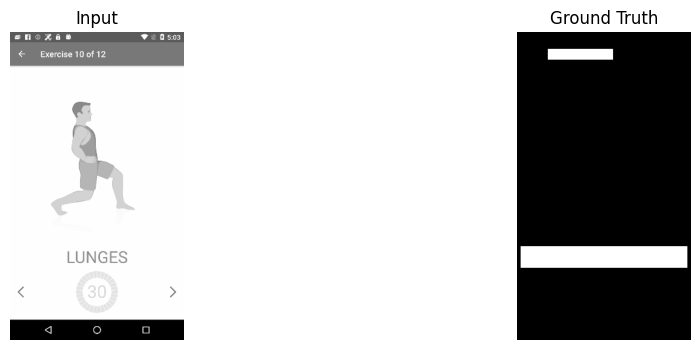

In [7]:
# Ejemplo de visualización
X_example, Y_example = load_image_pair_npy(3)
print("X_example shape:", X_example.shape if X_example is not None else "No image") 
print("Y_example shape:", Y_example.shape if Y_example is not None else "No mask")

if X_example is not None and Y_example is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Input")
    plt.imshow(X_example, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Ground Truth")
    plt.imshow(Y_example, cmap='gray')
    plt.axis('off')
    plt.show()
else:
    print("La imagen no está bien segmentada o no se pudo cargar.")

# Modelo

## Creacion modelo

### Auxiliar functions

In [5]:
def encoder_block(inputs, num_filters):

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation    
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    return x, p  # <-- x es skip connection, p va al siguiente encoder


def decoder_block(inputs, skip_features, num_filters):
    
    # Upsampling layer with 2x2 filter and stride of 2
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    
    # Concatenate the skip features with the upsampled input
    x = tf.keras.layers.Concatenate()([x, skip_features])
    
    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Convolution with 3x3 filter followed by ReLU activation
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


### Model construction

In [6]:
def unet_model(input_shape = (512, 288, 1), num_classes = 1, base_filters = 16):
    inputs = tf.keras.layers.Input(input_shape) # Shape: (512, 288, 3)

    # Contracting Path
    s1, p1 = encoder_block(inputs, base_filters) # Shape: (512, 288, 3) -> (256, 144, 16)
    s2, p2 = encoder_block(p1, base_filters * 2) # Shape: (256, 144, 16) -> (128, 72, 32)
    s3, p3 = encoder_block(p2, base_filters * 4) # Shape: (128, 72, 32) -> (64, 36, 64)
    s4, p4 = encoder_block(p3, base_filters * 8) # Shape: (64, 36, 64) -> (32, 18, 128)
    
    # Bottleneck
    b1 = tf.keras.layers.Conv2D(base_filters * 16, 3, padding='same')(p4)
    b1 = tf.keras.layers.Activation('relu')(b1) # Shape: (32, 18, 128) -> (32, 18, 256)
    b1 = tf.keras.layers.Conv2D(base_filters * 16, 3, padding='same')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1) # Shape: (32, 18, 256) -> (32, 18, 256)
    
    # Expansive Path
    d1 = decoder_block(b1, s4, base_filters * 8) # Shape: (32, 18, 256) -> (64, 36, 128)
    d2 = decoder_block(d1, s3, base_filters * 4) # Shape: (64, 36, 128) -> (128, 72, 64)
    d3 = decoder_block(d2, s2, base_filters * 2) # Shape: (128, 72, 64) -> (256, 144, 32)
    d4 = decoder_block(d3, s1, base_filters) # Shape: (256, 144, 32) -> (512, 288, 16)
    
    # Output
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding = 'same', activation = 'sigmoid')(d4) # Shape: (512, 288, 16) -> (512, 288, 1)
    
    model = tf.keras.models.Model(inputs = inputs, outputs = outputs, name = 'U-Net')
    return model

## Compilacion del modelo

In [7]:
base_filters = 16
model = unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), num_classes=1, base_filters=base_filters)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        BinaryAccuracy(name='acc'),
        MeanIoU(num_classes=2, name='iou')
    ]
)
model.summary()

I0000 00:00:1747204493.747429   13775 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 288,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 288,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 288,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 288,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 288,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 144,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 144,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 144,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 144,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 144,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 72,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 72,   │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128, 72,   │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 72,   │     36,928 │ activation_4[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 128, 72,   │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 36,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 36,    │     73,856 │ max_pooling2d_2[

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

In [8]:
# Ajusta esto si tus imágenes tienen otro tamaño o formato
IMG_SHAPE = (512, 288)  # (alto, ancho)
NUM_CHANNELS_X = 1
NUM_CHANNELS_Y = 1

# -------------------- Generador --------------------
def data_generator(index_list):
    for i in index_list:
        x, y = load_image_pair_npy(i, num_channels=NUM_CHANNELS_Y)
        if x is not None and y is not None:
            yield x, y

# -------------------- Dataset --------------------
def get_dataset(indices, batch_size=4, shuffle=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_generator(indices),
        output_signature=(
            tf.TensorSpec(shape=(IMG_SHAPE[0], IMG_SHAPE[1], NUM_CHANNELS_X), dtype=tf.float32),
            tf.TensorSpec(shape=(IMG_SHAPE[0], IMG_SHAPE[1], NUM_CHANNELS_Y), dtype=tf.float32)
        )
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
# -------------------- Entrenamiento --------------------
def train_model(model, total_images=3000, batch_size=2, epochs=50):
    # Dividir índices
    indices = list(range(total_images))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)
    
    # Crear datasets
    train_dataset = get_dataset(train_indices, batch_size=batch_size, shuffle=True)
    val_dataset   = get_dataset(val_indices, batch_size=batch_size, shuffle=False)

    # Directorios y callbacks
    save_dir = 'model/rico/unet_binary'
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, f'best_model_overall{base_filters}.keras')
    last_model_path = os.path.join(save_dir, f'last_model{base_filters}.keras')

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss')
    ]

    # Entrenar
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    # Guardar modelo final
    model.save(last_model_path)
    print(f"\n✅ Mejor modelo guardado en: {best_model_path}")
    print(f"✅ Modelo final guardado en: {last_model_path}")

    # Graficar métricas
    plot_training_curves(history)


# -------------------- Graficar curvas --------------------
def plot_training_curves(history):
    plt.figure(figsize=(18, 5))

    # Pérdida
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    if 'acc' in history.history:
        plt.subplot(1, 3, 2)
        plt.plot(history.history['acc'], label='Entrenamiento')
        plt.plot(history.history['val_acc'], label='Validación')
        plt.title('Precisión (Accuracy)')
        plt.xlabel('Épocas')
        plt.ylabel('Accuracy')
        plt.legend()

    # IoU
    if 'iou' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(history.history['iou'], label='Entrenamiento')
        plt.plot(history.history['val_iou'], label='Validación')
        plt.title('Intersección sobre Unión (IoU)')
        plt.xlabel('Épocas')
        plt.ylabel('IoU')
        plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/50


I0000 00:00:1747204511.743762   13928 service.cc:152] XLA service 0x7f65e40032c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747204511.743836   13928 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-14 01:35:11.881262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747204512.846570   13928 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-14 01:35:15.659256: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller

      2/Unknown 20s 91ms/step - acc: 0.8132 - iou: 0.4616 - loss: 0.6845

I0000 00:00:1747204524.302368   13928 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1002/Unknown 48s 28ms/step - acc: 0.8078 - iou: 0.4046 - loss: 0.5098

2025-05-14 01:35:51.987042: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-14 01:35:51.987073: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/mateo/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-05-14 01:35:58.010947: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - acc: 0.8078 - iou: 0.4046 - loss: 0.5098 - val_acc: 0.8121 - val_iou: 0.4061 - val_loss: 0.4778
Epoch 2/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.8216 - iou: 0.4072 - loss: 0.4480

2025-05-14 01:36:29.528129: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:36:29.528177: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970
2025-05-14 01:36:31.991236: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-14 01:36:31.991313: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:36:31.991361: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - acc: 0.8216 - iou: 0.4072 - loss: 0.4480 - val_acc: 0.8392 - val_iou: 0.4061 - val_loss: 0.4139
Epoch 3/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - acc: 0.8433 - iou: 0.4083 - loss: 0.4009 - val_acc: 0.8354 - val_iou: 0.4061 - val_loss: 0.4038
Epoch 4/50
1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.8431 - iou: 0.4074 - loss: 0.3989

2025-05-14 01:37:38.172033: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:37:38.172082: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - acc: 0.8431 - iou: 0.4074 - loss: 0.3989 - val_acc: 0.8462 - val_iou: 0.4061 - val_loss: 0.3911
Epoch 5/50


2025-05-14 01:37:40.152697: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-14 01:37:40.152729: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:37:40.152744: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8466 - iou: 0.4074 - loss: 0.3874 - val_acc: 0.8281 - val_iou: 0.4061 - val_loss: 0.4269
Epoch 6/50


2025-05-14 01:38:12.629089: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:38:12.629130: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8387 - iou: 0.4029 - loss: 0.4020 - val_acc: 0.8440 - val_iou: 0.4061 - val_loss: 0.3919
Epoch 7/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.8447 - iou: 0.4071 - loss: 0.3858

2025-05-14 01:39:17.241661: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8447 - iou: 0.4071 - loss: 0.3858 - val_acc: 0.8465 - val_iou: 0.4061 - val_loss: 0.3789
Epoch 8/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - acc: 0.8458 - iou: 0.4089 - loss: 0.3828 - val_acc: 0.8450 - val_iou: 0.4061 - val_loss: 0.3915
Epoch 9/50


2025-05-14 01:39:50.831457: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-14 01:39:50.831490: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:39:50.831505: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - acc: 0.8467 - iou: 0.4083 - loss: 0.3789 - val_acc: 0.8471 - val_iou: 0.4061 - val_loss: 0.3865
Epoch 10/50


2025-05-14 01:40:23.361168: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:40:23.361213: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.8518 - iou: 0.4084 - loss: 0.3660

2025-05-14 01:40:59.778301: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:40:59.778396: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - acc: 0.8518 - iou: 0.4084 - loss: 0.3660 - val_acc: 0.8478 - val_iou: 0.4061 - val_loss: 0.3769
Epoch 11/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.8414 - iou: 0.4030 - loss: 0.3863

2025-05-14 01:41:33.007095: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:41:33.007140: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970
2025-05-14 01:41:35.328071: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:41:35.328122: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - acc: 0.8414 - iou: 0.4030 - loss: 0.3863 - val_acc: 0.8470 - val_iou: 0.4061 - val_loss: 0.3737
Epoch 12/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - acc: 0.8411 - iou: 0.4042 - loss: 0.3800 - val_acc: 0.8481 - val_iou: 0.4061 - val_loss: 0.3734
Epoch 13/50


2025-05-14 01:42:09.514547: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888


1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.8458 - iou: 0.4048 - loss: 0.3730

2025-05-14 01:42:40.605290: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:42:40.605339: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - acc: 0.8458 - iou: 0.4048 - loss: 0.3730 - val_acc: 0.8460 - val_iou: 0.4061 - val_loss: 0.3735
Epoch 14/50


2025-05-14 01:42:42.667298: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:42:42.667342: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.8512 - iou: 0.4094 - loss: 0.3620

2025-05-14 01:43:15.881937: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:43:15.881990: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - acc: 0.8512 - iou: 0.4094 - loss: 0.3620 - val_acc: 0.8465 - val_iou: 0.4061 - val_loss: 0.3728
Epoch 15/50
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 29ms/step - acc: 0.8469 - iou: 0.4044 - loss: 0.3703 - val_acc: 0.8480 - val_iou: 0.4061 - val_loss: 0.3682
Epoch 16/50


2025-05-14 01:43:48.473641: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:43:48.473683: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8530 - iou: 0.4066 - loss: 0.3528 - val_acc: 0.8498 - val_iou: 0.4061 - val_loss: 0.3601
Epoch 17/50


2025-05-14 01:44:20.511350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8479 - iou: 0.4042 - loss: 0.3637 - val_acc: 0.8480 - val_iou: 0.4061 - val_loss: 0.3748
Epoch 18/50


2025-05-14 01:44:52.438668: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:44:52.438711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - acc: 0.8512 - iou: 0.4058 - loss: 0.3630 - val_acc: 0.8473 - val_iou: 0.4061 - val_loss: 0.3799
Epoch 19/50


2025-05-14 01:45:24.563890: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888


1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.8539 - iou: 0.4066 - loss: 0.3579

2025-05-14 01:45:55.264125: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:45:55.264250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - acc: 0.8539 - iou: 0.4066 - loss: 0.3579 - val_acc: 0.8485 - val_iou: 0.4061 - val_loss: 0.3604
Epoch 20/50


2025-05-14 01:45:57.665564: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:45:57.665614: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 34s 30ms/step - acc: 0.8508 - iou: 0.4049 - loss: 0.3568 - val_acc: 0.8420 - val_iou: 0.4061 - val_loss: 0.3653
Epoch 21/50


2025-05-14 01:46:31.416794: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:46:31.416835: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1001/1002 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.8485 - iou: 0.4024 - loss: 0.3641

2025-05-14 01:47:02.095305: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:47:02.095357: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970


1002/1002 ━━━━━━━━━━━━━━━━━━━━ 33s 30ms/step - acc: 0.8485 - iou: 0.4024 - loss: 0.3641 - val_acc: 0.8510 - val_iou: 0.4061 - val_loss: 0.3602


2025-05-14 01:47:04.340013: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11366983746459813888
2025-05-14 01:47:04.340061: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 18040330039950903970



✅ Mejor modelo guardado en: model/rico/unet_binary/best_model_overall16.keras
✅ Modelo final guardado en: model/rico/unet_binary/last_model16.keras


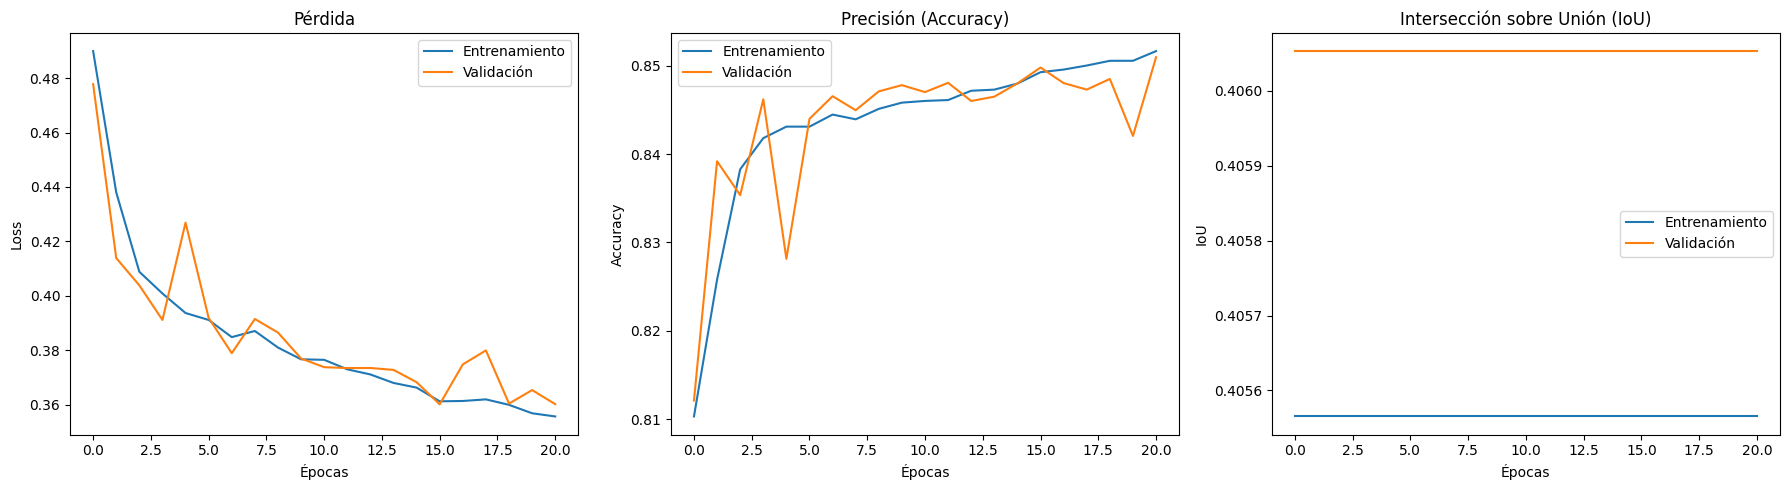

In [10]:
train_model(model, total_images=3000, batch_size=2, epochs=50)

# Prueba

In [12]:
best_model_path = f"model/rico/unet_binary/best_model_overall{base_filters}_gray.keras"
model = tf.keras.models.load_model(best_model_path, compile=True)
print(f"Modelo cargado: {best_model_path}")

# --- Preparar conjunto de test ---
eval_start = 9000
eval_end   = eval_start + 100
X_test, Y_test = [], []
ignored = 0

for i in range(eval_start, eval_end):
    x, y = load_image_pair_npy(i, num_channels=1)
    if x is None or y is None:
        ignored += 1
        continue
    X_test.append(x)
    Y_test.append(y)

X_test = np.stack(X_test, axis=0)
Y_test = np.stack(Y_test, axis=0)
print(f"Test loaded: {len(X_test)} samples, ignored {ignored}")

# --- Evaluación ---
results = model.evaluate(X_test, Y_test, batch_size=4, verbose=1)
print("\n📊 Resultados de evaluación:")
print(f"  Loss:    {results[0]:.4f}")
for name, value in zip(model.metrics_names[1:], results[1:]):
    print(f"  {name}: {value:.4f}")

Modelo cargado: model/rico/unet_binary/best_model_overall16_gray.keras
Test loaded: 96 samples, ignored 4
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.8333 - iou: 0.3926 - loss: 0.3986

📊 Resultados de evaluación:
  Loss:    0.3626
  compile_metrics: 0.8511


Entrada x shape: (512, 288, 1), Máscara y shape: (512, 288, 1)
Tipo de x: <class 'numpy.ndarray'> | dtype: float32
Forma para predict: (1, 512, 288, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


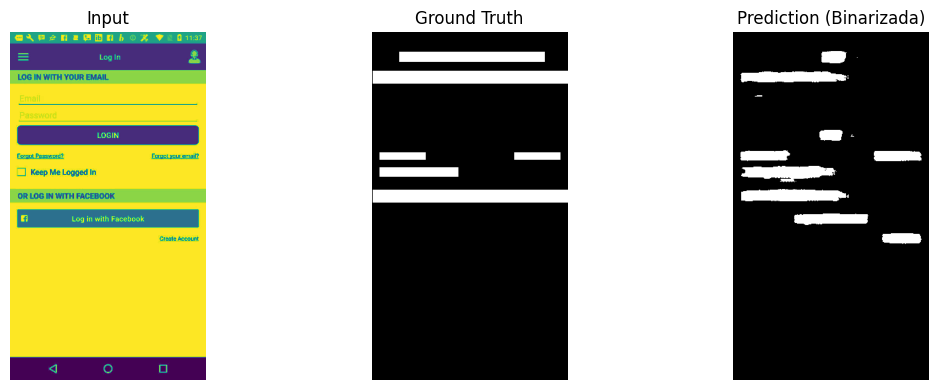

In [13]:
def show_prediction(idx):
    # Cargar con la nueva función que devuelve un canal
    x, y = load_image_pair_npy(idx, num_channels=1)
    if x is None or y is None:
        print("No se pudo cargar la imagen o no tiene texto detectado.")
        return

    print(f"Entrada x shape: {x.shape}, Máscara y shape: {y.shape}")
    print("Tipo de x:", type(x), "| dtype:", x.dtype)

    # Asegurar rango [0,1]
    if x.max() > 1.0:
        x = x / 255.0

    # Asegura batch dimension
    x_batch = np.expand_dims(x, axis=0)
    print("Forma para predict:", x_batch.shape)

    # Predicción
    pred = model.predict(x_batch)[0]  # shape (512, 288, 1)

    # Extraer canal
    true_mask = y[:, :, 0]
    pred_mask = pred[:, :, 0]

    # Umbral en 0.5
    binary_mask = (pred_mask >= 0.5).astype(np.uint8)  # 0 o 1

    # Plot
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(x)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(true_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Prediction (Binarizada)")
    plt.imshow(binary_mask, cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Mostrar ejemplo
show_prediction(100)